In [62]:
from pathlib import Path

import networkx as nx
from networkx.algorithms import community
import powerlaw

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import LinearRegression
from itertools import combinations

In [63]:
plt.style.use("dark_background")

In [64]:
SEED = 123

In [65]:
GEXF_PATH = Path.cwd() / "data" / "lichess_top1500_standard_rated_06_2016.gexf"
assert GEXF_PATH.exists()

In [66]:
G = nx.read_gexf(GEXF_PATH)

In [67]:
# Clearly define what are nodes, what are edges in your network
# A node is a lichess player. Its attribures are its name (label) and rating
list(G.nodes(data=True))[123]

('bulkong', {'rating': 2413, 'label': 'bulkong'})

In [68]:
# An edge appears between players if they have ever played a game together.
# It's weight is an ampunt of games they played together total
list(G.edges(data=True))[123]

('hiimgosu', 'chessstrategy', {'id': '123', 'weight': 3.0})

In [69]:
# The type of the network:
# directed/undirected, heterogeneous/homogeneous, weighted/unweighted, etc.
# The graph is  undirected homogeneous and weighted.
# It has 11 connected components,
# and we are going to work with only the largest one.
len(list(nx.connected_components(G)))

11

In [70]:
def get_largest_part(G):
    nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(nodes)

In [71]:
# Возьмем самую большую компоненту связности
G = get_largest_part(G)

# Number of nodes and edges.
# В графе 1231 узлов и 3994 ребер.
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 1231, Edges: 3994


In [72]:
def alpha_log_bins(x_train, bins):
    logspace = np.logspace(
        np.log(np.min(x_train)),
        np.log(np.max(x_train)),
        bins
    )

    hist, bin_edges = np.histogram(
        x_train,
        bins=logspace,
        density=True
    )

    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    idx = np.argwhere(hist > 0)

    log_centers = np.log(bin_centers[idx][:,0]).reshape(-1, 1)
    log_hist = np.log(hist[idx][:,0])

    lr = LinearRegression().fit(log_centers, log_hist)

    return -lr.coef_[0], bin_centers[idx], hist[idx], lr

In [73]:
degrees = [deg for _, deg in G.degree()]

In [74]:
alpha, bin_centers, hist, lr = alpha_log_bins(degrees, bins=500)

In [75]:
# Настоящие наблюдения
x, counts = np.unique(degrees, return_counts=True)
y = counts / len(degrees)

# Для регрессии
x_min, x_max = min(degrees), max(degrees)
x_fit = np.logspace(np.log10(x_min), np.log10(x_max), 100)
y_fit = np.exp(lr.intercept_ - alpha * np.log(x_fit))

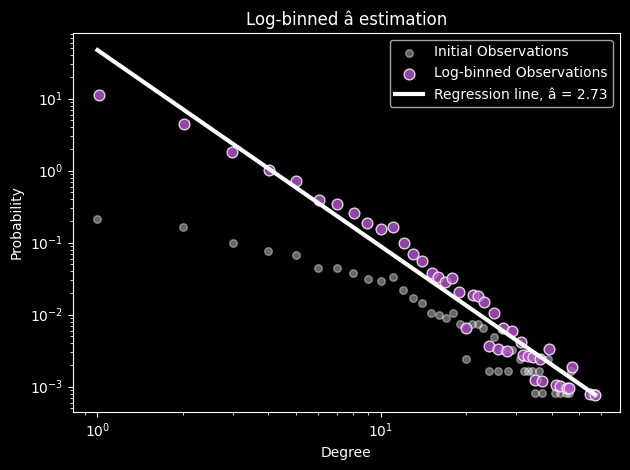

In [76]:
plt.scatter(
    x,
    y,
    color="white",
    alpha=0.4,
    s=30,
    label="Initial Observations",
)

plt.scatter(
    bin_centers,
    hist,
    color="mediumorchid",
    alpha=0.8,
    s=60,
    edgecolor="white",
    label="Log-binned Observations",
)

plt.plot(
    x_fit,
    y_fit,
    color="white",
    linewidth=3,
    label=f"Regression line, â = {alpha:.2f}"
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title(f"Log-binned â estimation")
plt.legend()


plt.tight_layout()
plt.show()

In [77]:
fit = powerlaw.Fit(degrees, discrete=True)

Calculating best minimal value for power law fit


In [78]:
# Оценка â говорит о том, что скорее сеть является scale-free,
# хоть и близко к random.

print(f"Log binning â: {alpha:.3f}")
print(f"powerlaw lib â: {fit.alpha:.3f}, xmin: {fit.xmin}")


Log binning â: 2.726
powerlaw lib â: 2.974, xmin: 10.0


In [79]:
def empirical_cdf(g: nx.Graph) -> list[float]:
    hist = nx.degree_histogram(g)
    return np.cumsum(hist) / np.sum(hist)

def power_law_cdf(x, alpha=3.5, x_min=1):
    return 1 - x ** (-alpha + 1) / x_min ** (-alpha + 1)

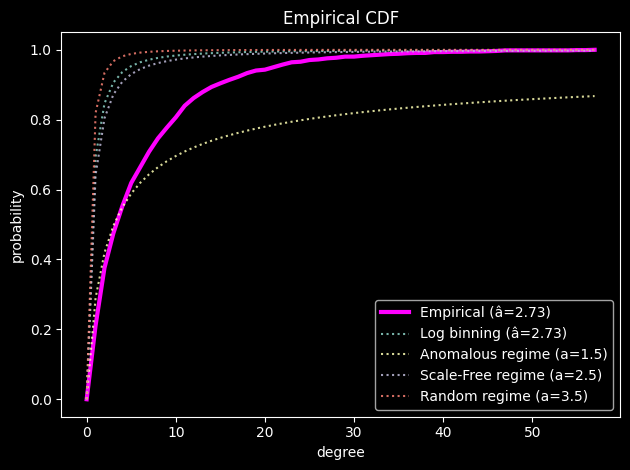

In [80]:
# Degree distribution. Is your network scale-free?
# Compare with what is expected in a random network

ecdf = empirical_cdf(G)

maxdeg = max(G.degree(), key=lambda node: node[1])[1]

x_space = np.linspace(1, maxdeg, len(ecdf))

plt.plot(ecdf, label=f"Empirical (â={alpha:.2f})",
         color="fuchsia", linewidth=3)

plt.plot(power_law_cdf(x_space, alpha=alpha), ":",
         label=f"Log binning (â={alpha:.2f})" , alpha=0.85)

plt.plot(power_law_cdf(x_space, alpha=1.5)  , ":",
         label="Anomalous regime (a=1.5)"     , alpha=0.85)

plt.plot(power_law_cdf(x_space, alpha=2.5)  , ":",
         label="Scale-Free regime (a=2.5)"    , alpha=0.85)

plt.plot(power_law_cdf(x_space, alpha=3.5)  , ":",
         label="Random regime (a=3.5)"        , alpha=0.85)

plt.xlabel('degree')
plt.ylabel('probability')
plt.title('Empirical CDF')

plt.legend()
plt.tight_layout()
plt.show()

In [81]:
fit_w_xmin = powerlaw.Fit(degrees, discrete=True, xmin=x_min, xmax=x_max)

print(f"Log-binned â: {alpha:.2f}")
print(f"Auto-xmin ({fit.xmin:.0f}) â: {fit.alpha:.2f}")
print(f"Strict xmin ({fit_w_xmin.xmin:.0f}) â: {fit_w_xmin.alpha:.2f}")

Log-binned â: 2.73
Auto-xmin (10) â: 2.97
Strict xmin (1) â: 1.24


In [82]:
def power_law_ppf(r, alpha=3.5, x_min=1):
    return (1 - r) ** (1/(-alpha + 1)) * x_min

In [83]:
def qqplot_data(observations, alpha, x_min):
    probs = np.arange(0, 1, 0.01)
    qt = power_law_ppf(probs, alpha, x_min)
    qe = np.quantile(observations, probs)
    return qt, qe

In [84]:
theor_sf, empir_sf = qqplot_data(degrees, fit.alpha, fit.xmin)
theor_anom, empir_anom = qqplot_data(
    degrees,
    fit_w_xmin.alpha,
    fit_w_xmin.xmin
)

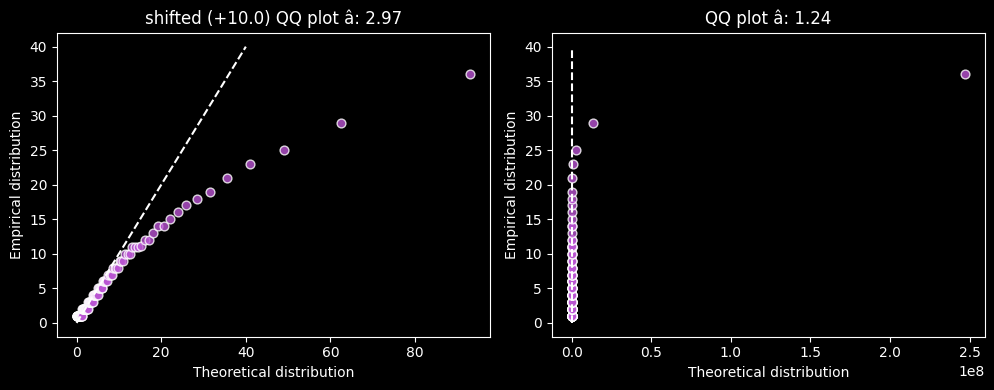

In [85]:
plt.figure(figsize=(15, 4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1)
plt.scatter([c - fit.xmin for c in theor_sf], empir_sf, s=40,
            color="mediumorchid", alpha=0.8, edgecolors="white")
plt.plot([0, 40], [0, 40], '--', color='white')
plt.title(f'shifted (+{fit.xmin}) QQ plot â: {fit.alpha:.2f}')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')

plt.subplot(1, 3, 2)
plt.scatter(theor_anom, empir_anom, s=40,
            color="mediumorchid", alpha=0.8,edgecolors="white")
plt.plot([0, 40], [0, 40], '--', color='white')
plt.title(f'QQ plot â: {fit_w_xmin.alpha:.2f}')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')

plt.tight_layout()
plt.show()

### The network is anomalous with scale-free tendencies.

It matches power-law at higher degrees, but has fewer extreme hubs than predicted.

It is mostly anomalous il lower degrees, which are significantly lesser than expected within power-law.

In [86]:
# Average distance. Is your network small-world?
# Compare with what is expected in a random network
# Clustering coefficient. Does your network demonstrate high clustering?
# Compare with what is expected in a random network

shortest_pl = nx.average_shortest_path_length(G)
diam = nx.diameter(G)
cluster = nx.average_clustering(G)
print("Lichess top rated players network")
print(f"Avg shortest path len: {shortest_pl:.3f}; "\
      "diameter: {diam}; avg clustering: {cluster:.3f}")

Lichess top rated players network
Avg shortest path len: 4.228; diameter: {diam}; avg clustering: {cluster:.3f}


In [87]:
def estimate_binomial(G):
    return len(G), np.mean([G.degree[n] for n in G.nodes]) / len(G)

In [88]:
random_from_real = lambda graph: nx.erdos_renyi_graph(
    *estimate_binomial(graph),
    seed=SEED
)

In [89]:
G_er = random_from_real(G)
G_er = get_largest_part(G_er)
shortest_pl_er = nx.average_shortest_path_length(G_er)
diam_er = nx.diameter(G_er)
cluster_er = nx.average_clustering(G_er)
print("ER network")
print(f"Avg shortest path len: {shortest_pl_er:.3f}; "\
      "diameter: {diam_er}; avg clustering: {cluster_er:.3f}")

ER network
Avg shortest path len: 4.026; diameter: {diam_er}; avg clustering: {cluster_er:.3f}


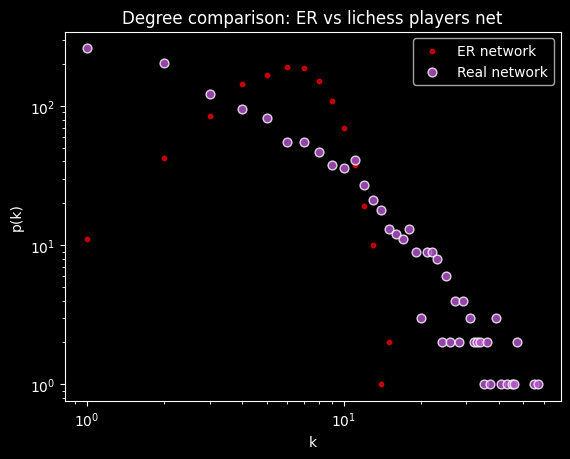

In [90]:
degree_hist = np.array(nx.degree_histogram(G_er))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=10, label='ER network', color="red", alpha=0.7)

degree_hist = np.array(nx.degree_histogram(G))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=40, label='Real network',
            color="mediumorchid", alpha=0.8, edgecolors="white")

plt.legend()
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title("Degree comparison: ER vs lichess players net")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [91]:
n = G.number_of_nodes()
m = G.number_of_edges()
avg_deg = int(np.average(degrees))

G_ba = nx.barabasi_albert_graph(n, avg_deg)
G_ba = get_largest_part(G_ba)
shortest_pl_ba = nx.average_shortest_path_length(G_ba)
diam_ba = nx.diameter(G_ba)
cluster_ba = nx.average_clustering(G_ba)
print("BA network")
print(f"Avg shortest path len: {shortest_pl_ba:.3f}; diameter: "\
      "{diam_ba}; avg clustering: {cluster_ba:.3f}")

BA network
Avg shortest path len: 2.892; diameter: {diam_ba}; avg clustering: {cluster_ba:.3f}


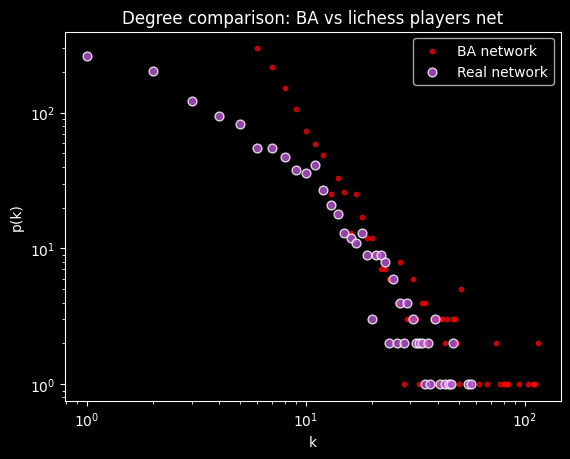

In [92]:
degree_hist = np.array(nx.degree_histogram(G_ba))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=10,
            label='BA network', color="red", alpha=0.7)

degree_hist = np.array(nx.degree_histogram(G))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=40, label='Real network',
            color="mediumorchid", alpha=0.8, edgecolors="white")

plt.legend()
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title("Degree comparison: BA vs lichess players net")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [93]:
G_ws = nx.watts_strogatz_graph(n, avg_deg, 0.1, seed=SEED)
G_ws = get_largest_part(G_ws)
shortest_pl_ws = nx.average_shortest_path_length(G_ws)
diam_ws = nx.diameter(G_ws)
cluster_ws = nx.average_clustering(G_ws)
print("WA network")
print(f"Avg shortest path len: {shortest_pl_ws:.3f}; "\
      "diameter: {diam_ws}; avg clustering: {cluster_ws:.3f}")

WA network
Avg shortest path len: 6.330; diameter: {diam_ws}; avg clustering: {cluster_ws:.3f}


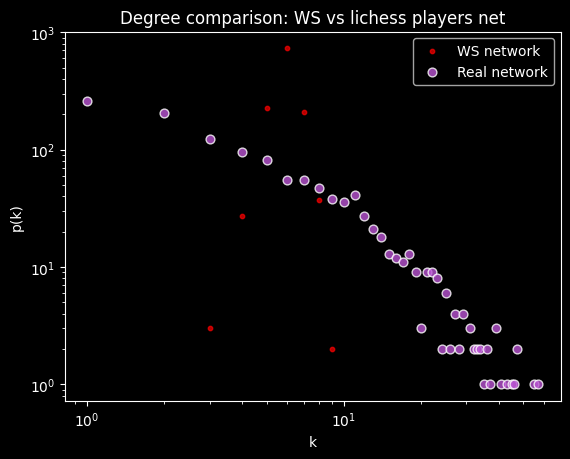

In [94]:
degree_hist = np.array(nx.degree_histogram(G_ws))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=10, label='WS network',
            color="red", alpha=0.7)

degree_hist = np.array(nx.degree_histogram(G))
idx = np.argwhere(degree_hist > 0)
plt.scatter(idx, degree_hist[idx], s=40, label='Real network',
            color="mediumorchid", alpha=0.8, edgecolors="white")

plt.legend()
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title("Degree comparison: WS vs lichess players net")
plt.xscale('log')
plt.yscale('log')
plt.show()

### The network exhibits a small-world property,

with average shortest path length equal to 4.228, similar to random networks, but higher clustering (0.066, 11 times higher compared to random estimation)

It's average path length is close to ER (4.026), which means that is has random-like path lengths.

It is longer than BA (2.902) probably due to less powerful hubs: while very active players exist, interactions between all players are still mostly random, and hub property to connect smaller-degree nodes is less influential.

Network's diameter (12) is much larger than expected in random(ER 7, BA 5), which is obvious because hubs are still less influential due to partially random nature of the network but is equal in one from WS (12) because they both probably have similar connectivity bottlenecks.

While clustering coef (0.066) is significantly higher compared to random ER (0.006) and BA (0.036), it is smaller than WS (0.437), which suggests adequate community destribution rather than tightly-knit cliques.


In [95]:
# Present a gorgeous network layout.
# Try to show that your network has some structure, play with node sizes and colors, scaling parameters.

In [96]:
pos = nx.spring_layout(G, k=2.9, iterations=100, seed=SEED)

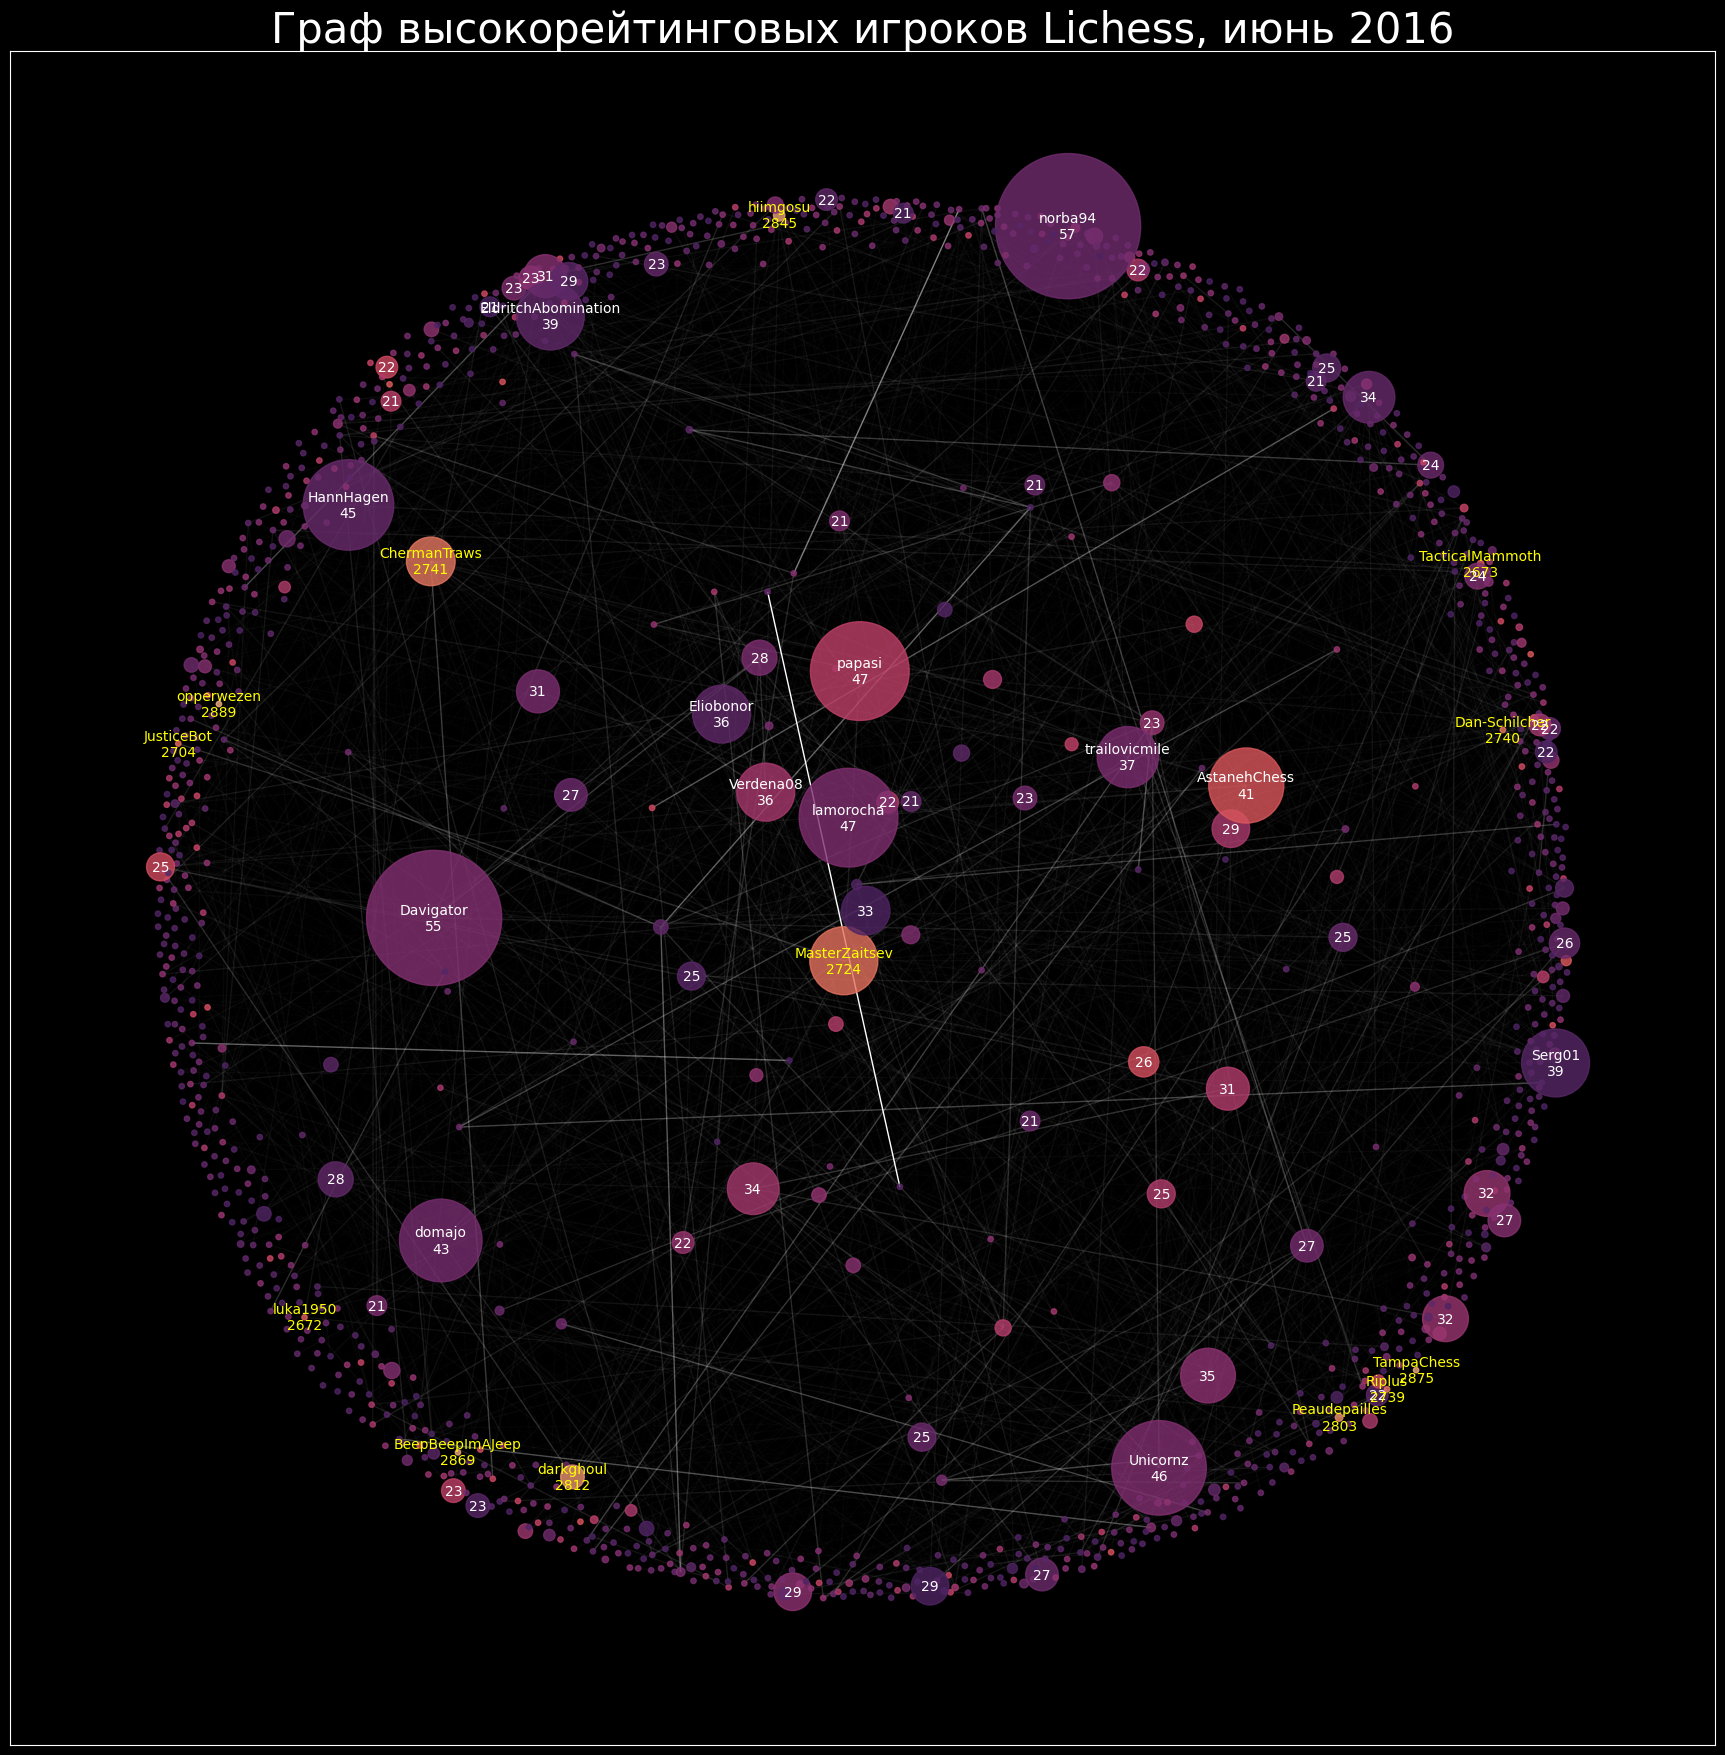

In [97]:
# Узлы:

ratings = [G.nodes[node]["rating"] for node in G.nodes()]
ratings_norm = (
    np.array(ratings) - min(ratings)) / (max(ratings) - min(ratings)
)

palette = sns.color_palette("flare_r", as_cmap=True)
node_colors = [palette(r) for r in ratings_norm]

degrees = dict(G.degree())
degree_vals = list(degrees.values())
max_deg = max(degree_vals)

node_sizes = []

for node in G.nodes():
    cur_size =  (G.degree(node)**4 + 200) / (max_deg**1.7)
    node_sizes.append(max(cur_size, 15))


# Подписи

q95_deg, q99_deg = np.quantile(degree_vals, (0.95, 0.99))
q99_elo = np.quantile(ratings, 0.99)
labels = dict()
label_colors = dict()
for node in G.nodes():

    cur_deg = degrees[node]
    cur_elo = G.nodes[node]["rating"]

    if cur_elo >= q99_elo:
        cur_label = str(cur_elo)
        cur_color = (1, 1, 0, 1)  # yellow
        cur_label = f"{node}\n{cur_elo}"

    elif cur_deg >= q95_deg:
        cur_label = str(cur_deg)
        cur_color = (1, 1, 1, 1)  # white
        if cur_deg >= q99_deg:
            cur_label = f"{node}\n" + cur_label

    else:
        cur_color = (0, 0, 0, 0)  # invisible black
        cur_label = ""

    labels[node] = cur_label
    label_colors[node] = cur_color


# Ребра

edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)
edge_alphas = []
edge_colors = []
for w in edge_weights:
    norm_weight = (w - min_weight) / (max_weight - min_weight)
    edge_alphas.append(norm_weight)
    edge_colors.append("white")


# Рисуем

plt.figure(figsize=(22, 22))

nx.draw_networkx_nodes(G, pos, alpha=0.8, node_size=node_sizes,
                       node_color=node_colors)
nx.draw_networkx_edges(G, pos,
                       alpha=edge_alphas, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, font_size=10,
                        labels=labels, font_color=label_colors)

plt.title(f"Граф высокорейтинговых игроков Lichess, июнь 2016", fontsize=30)
plt.show()

In [98]:
# Centrality measures.
# Find top nodes by Degree, Betweenness,
# Closeness, Eigenvector centrality.
# Why are these people the top nodes in your network?
# Show how your friends’ personal properties
# correspond to nodes’ structural properties.

In [99]:
# These have most games against different opponents
degree_centrality = nx.degree_centrality(G)

In [100]:
# These play in different groups
betweenness_centrality = nx.betweenness_centrality(G)

In [101]:
# These are closest to all other players
closeness_centrality = nx.closeness_centrality(G)

In [102]:
# These must be a group of most active players
# Hypothesis: they are equal to degree centrality
# H0: there is no correlation between eigenvector and degree centralities
# H1: there is statistically significant
# correlation between eigenvector and degree centralities
eigenvector_centrality = nx.eigenvector_centrality(G)

In [103]:
data = []
for node in G.nodes():
    data.append({
        "player"     : node,
        "ELO"        : G.nodes[node]["rating"],
        "degree"     : degree_centrality[node],
        "betweenness": betweenness_centrality[node],
        "closeness"  : closeness_centrality[node],
        "eigenvector": eigenvector_centrality[node],
    })

df = pd.DataFrame(data)

In [104]:
print("Top players by degree centrality")
df.sort_values("degree", ascending=False).head()

Top players by degree centrality


player   ELO    degree  betweenness  closeness  eigenvector
616     norba94  2330  0.046341     0.045804   0.327215     0.010318
136   Davigator  2384  0.044715     0.046040   0.333063     0.010017
1094     papasi  2551  0.038211     0.018984   0.306504     0.232982
674   lamorocha  2374  0.038211     0.010777   0.298616     0.241072
813    Unicornz  2376  0.037398     0.025296   0.318488     0.194750

In [105]:
print("Top players by betweenness centrality")
df.sort_values("betweenness", ascending=False).head()

Top players by betweenness centrality


player   ELO    degree  betweenness  closeness  eigenvector
136  Davigator  2384  0.044715     0.046040   0.333063     0.010017
616    norba94  2330  0.046341     0.045804   0.327215     0.010318
475     domajo  2350  0.034959     0.044514   0.328263     0.008674
204  Killerkaz  2414  0.023577     0.040976   0.323174     0.030742
578  HannHagen  2312  0.036585     0.040727   0.331715     0.008061

In [106]:
print("Top players by closeness centrality")
df.sort_values("closeness", ascending=False).head()

Top players by closeness centrality


player   ELO    degree  betweenness  closeness  eigenvector
136  Davigator  2384  0.044715     0.046040   0.333063     0.010017
578  HannHagen  2312  0.036585     0.040727   0.331715     0.008061
475     domajo  2350  0.034959     0.044514   0.328263     0.008674
616    norba94  2330  0.046341     0.045804   0.327215     0.010318
782  Eliobonor  2289  0.029268     0.025096   0.326433     0.009308

In [107]:
print("Top players by eigenvector centrality")
df.sort_values("eigenvector", ascending=False).head()

Top players by eigenvector centrality


player   ELO    degree  betweenness  closeness  eigenvector
674             lamorocha  2374  0.038211     0.010777   0.298616     0.241072
1094               papasi  2551  0.038211     0.018984   0.306504     0.232982
1156               Serg01  2259  0.031707     0.004170   0.291953     0.229433
1069  EldritchAbomination  2285  0.031707     0.003732   0.287719     0.228470
1096         AstanehChess  2652  0.033333     0.008293   0.295460     0.219475

In [108]:
stats.shapiro(df["degree"])

ShapiroResult(statistic=np.float64(0.7211171397446602), pvalue=np.float64(3.799953885698123e-41))

In [109]:
target_cols = [
    "degree",
    "betweenness",
    "closeness",
    "eigenvector",
    "ELO"
]

# max col len for formatting
mcl = len(max(target_cols))

In [110]:
# All abnormally distributed, use spearmanr

for col in target_cols:
    s, p = stats.shapiro(df[col].values)
    print(f"{col:<{mcl}} shapiro(r={s:.3f}, p={p:.3f})")

degree      shapiro(r=0.721, p=0.000)
betweenness shapiro(r=0.552, p=0.000)
closeness   shapiro(r=0.992, p=0.000)
eigenvector shapiro(r=0.310, p=0.000)
ELO         shapiro(r=0.873, p=0.000)


In [111]:
for c1, c2 in combinations(target_cols, 2):
    cvals_1 = df[c1].values
    cvsls_2 = df[c2].values

    r, p = stats.spearmanr(cvals_1, cvsls_2)

    print(f"{c1:<{mcl}} vs {c2:<{mcl}}: spearmanr(r={r:.3f}, p={p:.3f})")

degree      vs betweenness: spearmanr(r=0.897, p=0.000)
degree      vs closeness  : spearmanr(r=0.873, p=0.000)
degree      vs eigenvector: spearmanr(r=0.753, p=0.000)
degree      vs ELO        : spearmanr(r=0.185, p=0.000)
betweenness vs closeness  : spearmanr(r=0.724, p=0.000)
betweenness vs eigenvector: spearmanr(r=0.557, p=0.000)
betweenness vs ELO        : spearmanr(r=0.127, p=0.000)
closeness   vs eigenvector: spearmanr(r=0.839, p=0.000)
closeness   vs ELO        : spearmanr(r=0.241, p=0.000)
eigenvector vs ELO        : spearmanr(r=0.252, p=0.000)


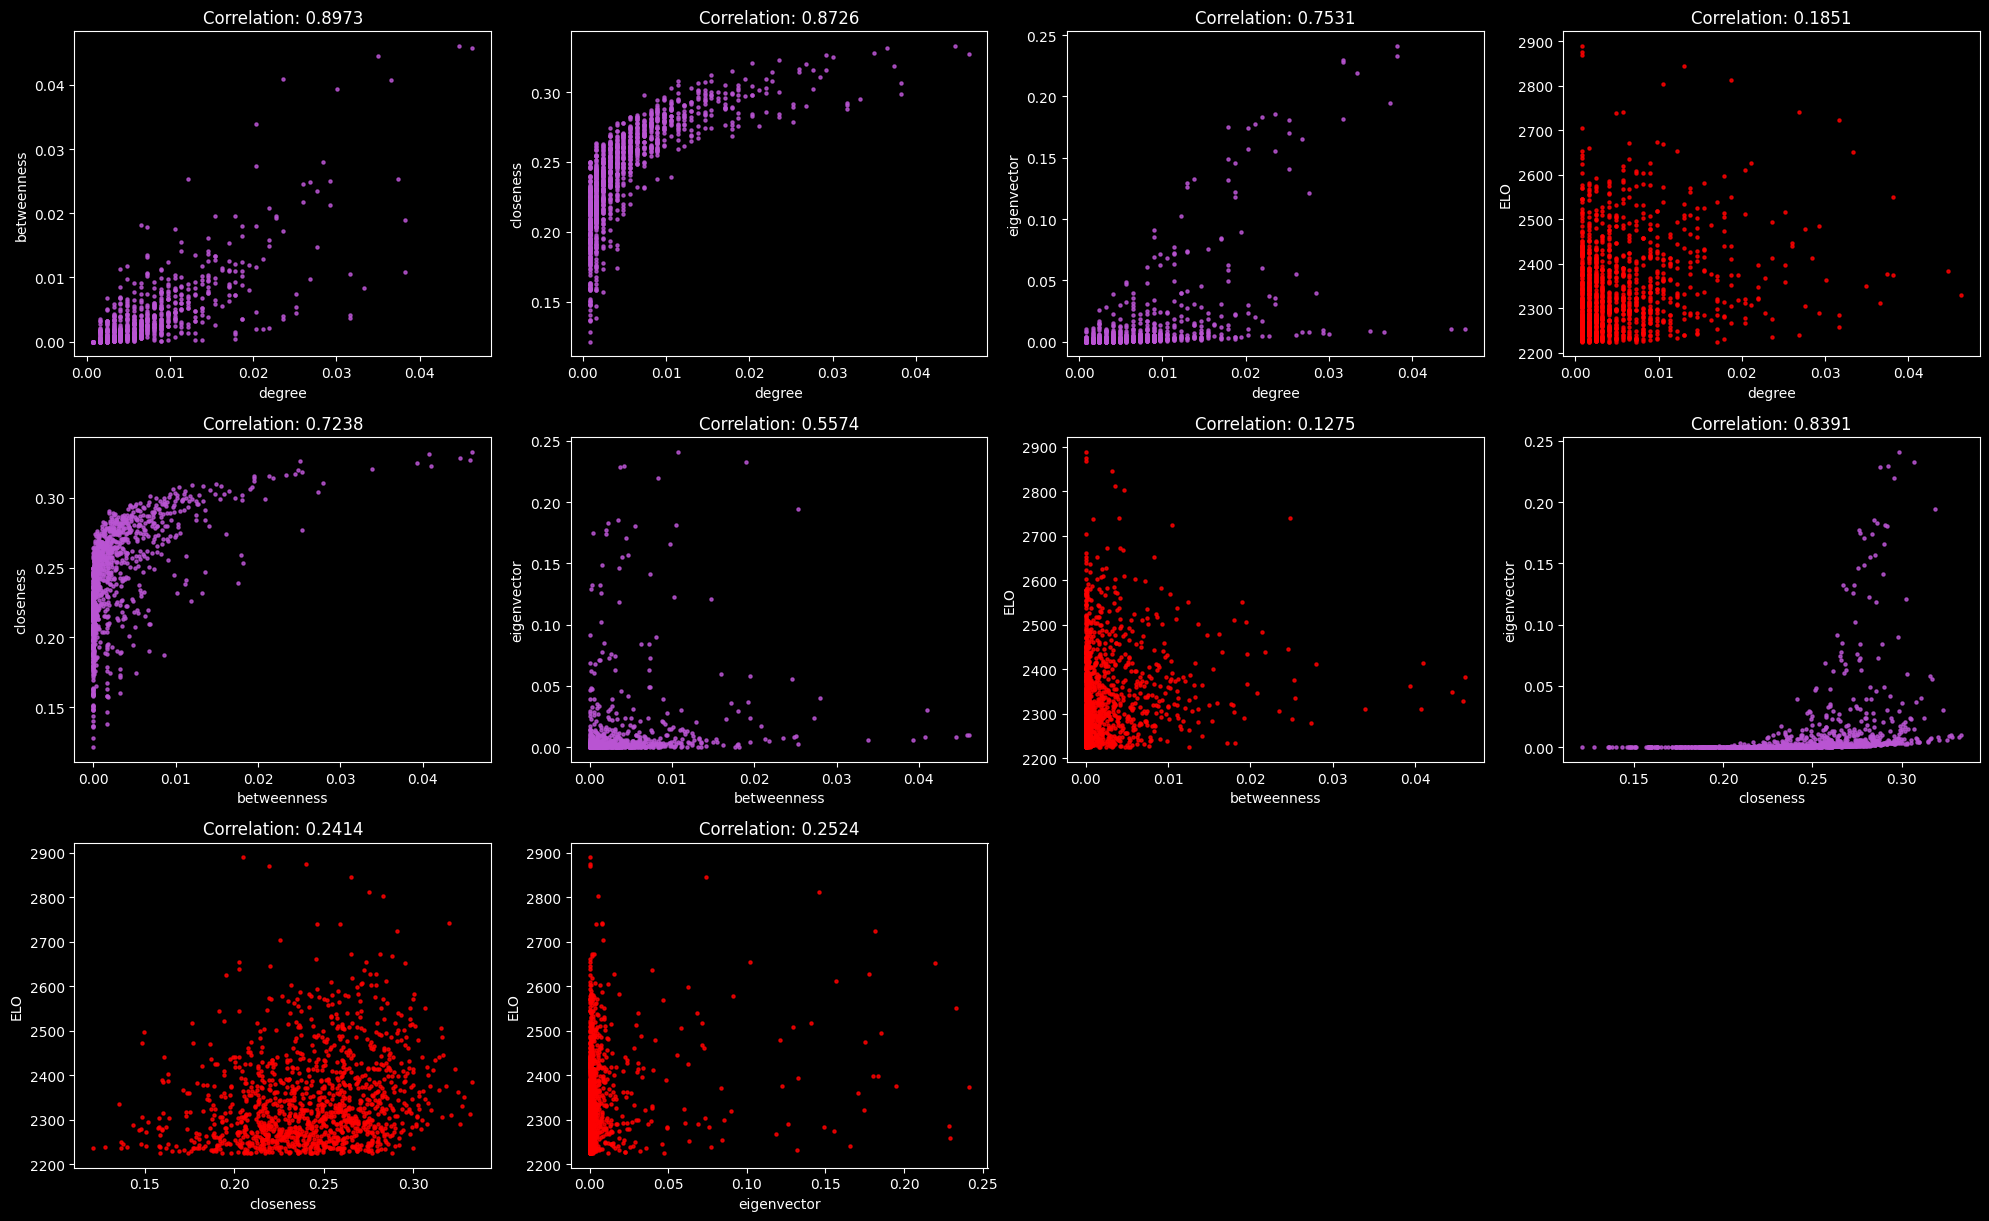

In [112]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
k = 1

for c1, c2 in combinations(target_cols, 2):
    cvals_1 = df[c1].values
    cvsls_2 = df[c2].values

    r, p = stats.spearmanr(cvals_1, cvsls_2)

    if c1 == "ELO" or c2 == "ELO":
        color = "red"
    else:
        color = "mediumorchid"

    plt.subplot(5, 4, k)
    plt.scatter(cvals_1, cvsls_2, s=5, color=color, alpha=0.8)
    plt.title('Correlation: {:.4f}'.format(r))
    plt.xlabel(c1)
    plt.ylabel(c2)
    k += 1

plt.tight_layout()
plt.show()

### Extremely high centrality correlations are observed

with degree centrality being dominant. This means that players with many opponents also are the most important (eigenvector) bridge different player groups (betweenness) and are the most central (closeness) (which can be partially observed on the gorgeous layout above).

Also a very low corellation between ELO rating and centraliry values is observed. H0 is rejected. This means that player activity and skill level are not dependant on each other.

In [113]:
# H0.1: more active players tend to play with more active players
assortativity_deg = nx.degree_assortativity_coefficient(G)

# H0.2: higher rated players tend to play with higher rated players
assortativity_elo = nx.attribute_assortativity_coefficient(G, "rating")

print(f"Assortativity by degree:  {assortativity_deg:.3f}")
print(f"Assortativity by ELO   : {assortativity_elo:.3f}")

Assortativity by degree:  0.150
Assortativity by ELO   : -0.003


### The network is assorative by degree, but not by attribute (ELO rating)

This means that active players tend to play other active players (degree assortativity 0.150): H0.1 regected.

However, -0.003 assortativity coefficient on ELO shows that higher rated players in fact play all others (coef nerly 0), which means that matchmakeing system ranges all the players in the network as mostly equal in skill level, and H0.2 can't be regected.

In [114]:
# Apply 2-3 community detection algorithms and compare them by Modularity.

In [ ]:
gn = community.girvan_newman(G)

# set True to test. WARNING: this is SLOW
RUN_GN = False

In [116]:
## WARNING: This is SLOW
if RUN_GN:
    communities_gn_1 = list(next(gn))
    mod_gn_1 = community.modularity(G, communities_gn_1)
    print("Step 1")
    print(f"Communities found: {len(communities_gn_1)}")
    print(f"Vodularity: {mod_gn_1:.3f}")

    print()

    print("Step 2")
    communities_gn_2 = list(next(gn))
    mod_gn_2 = community.modularity(G, communities_gn_2)
    print(f"Communities found: {len(communities_gn_2)}")
    print(f"Modularity: {mod_gn_2:.3f}")

Step 1
Communities found: 2
Vodularity: 0.004

Step 2
Communities found: 3
Modularity: 0.023


In [117]:
communities_louvain = list(community.louvain_communities(G, seed=SEED))
mod_louvain = community.modularity(G, communities_louvain)
print(f"Communities found: {len(communities_louvain)}")
print(f"Modularity: {mod_louvain:.3f}")

Communities found: 16
Modularity: 0.594


In [118]:
communities_labelprop = list(community.label_propagation_communities(G))
mod_labelprop = community.modularity(G, communities_labelprop)
print(f"Communities found: {len(communities_labelprop)}")
print(f"Modularity: {mod_labelprop:.3f}")

Communities found: 54
Modularity: 0.273


### Louvain method proved to be the best for this specific network.

Modularity 0.594 for it shows a very strong community structure. This is probably because players have played on different days and/on different hours of day. It is also likely to encounter some niche tournaments int this network, whick just might be communities aswell.

Label Propagation algorithm showed poor performance with modelarity = 0.023.

Girvan-Newman algorithm also showed poor performance on early steps (step 1 0.004, step 2 0.023). It must be noted though that it might perform better during further steps. However it is also terribly slow, which is also not one of its advantages. Thats why we can also consider it bat for this specific task.

In [119]:
node2community = {}
for i, comm in enumerate(communities_louvain):
    for node in comm:
        node2community[node] = i

num_communities = len(communities_louvain)

# make a color mapping for communities
cmap = plt.get_cmap("coolwarm", num_communities)

edge_colors = []
for u, v in G.edges():
    edge_colors.append(cmap(node2community[u]))

In [120]:
communities_sorted = sorted(communities_louvain, key=len, reverse=True)

In [121]:
# make generator for plot positions

def gen_ij(maxi, maxj):
    for i in range(maxi):
        for j in range(maxj):
            yield i, j

<Figure size 2000x2000 with 0 Axes>

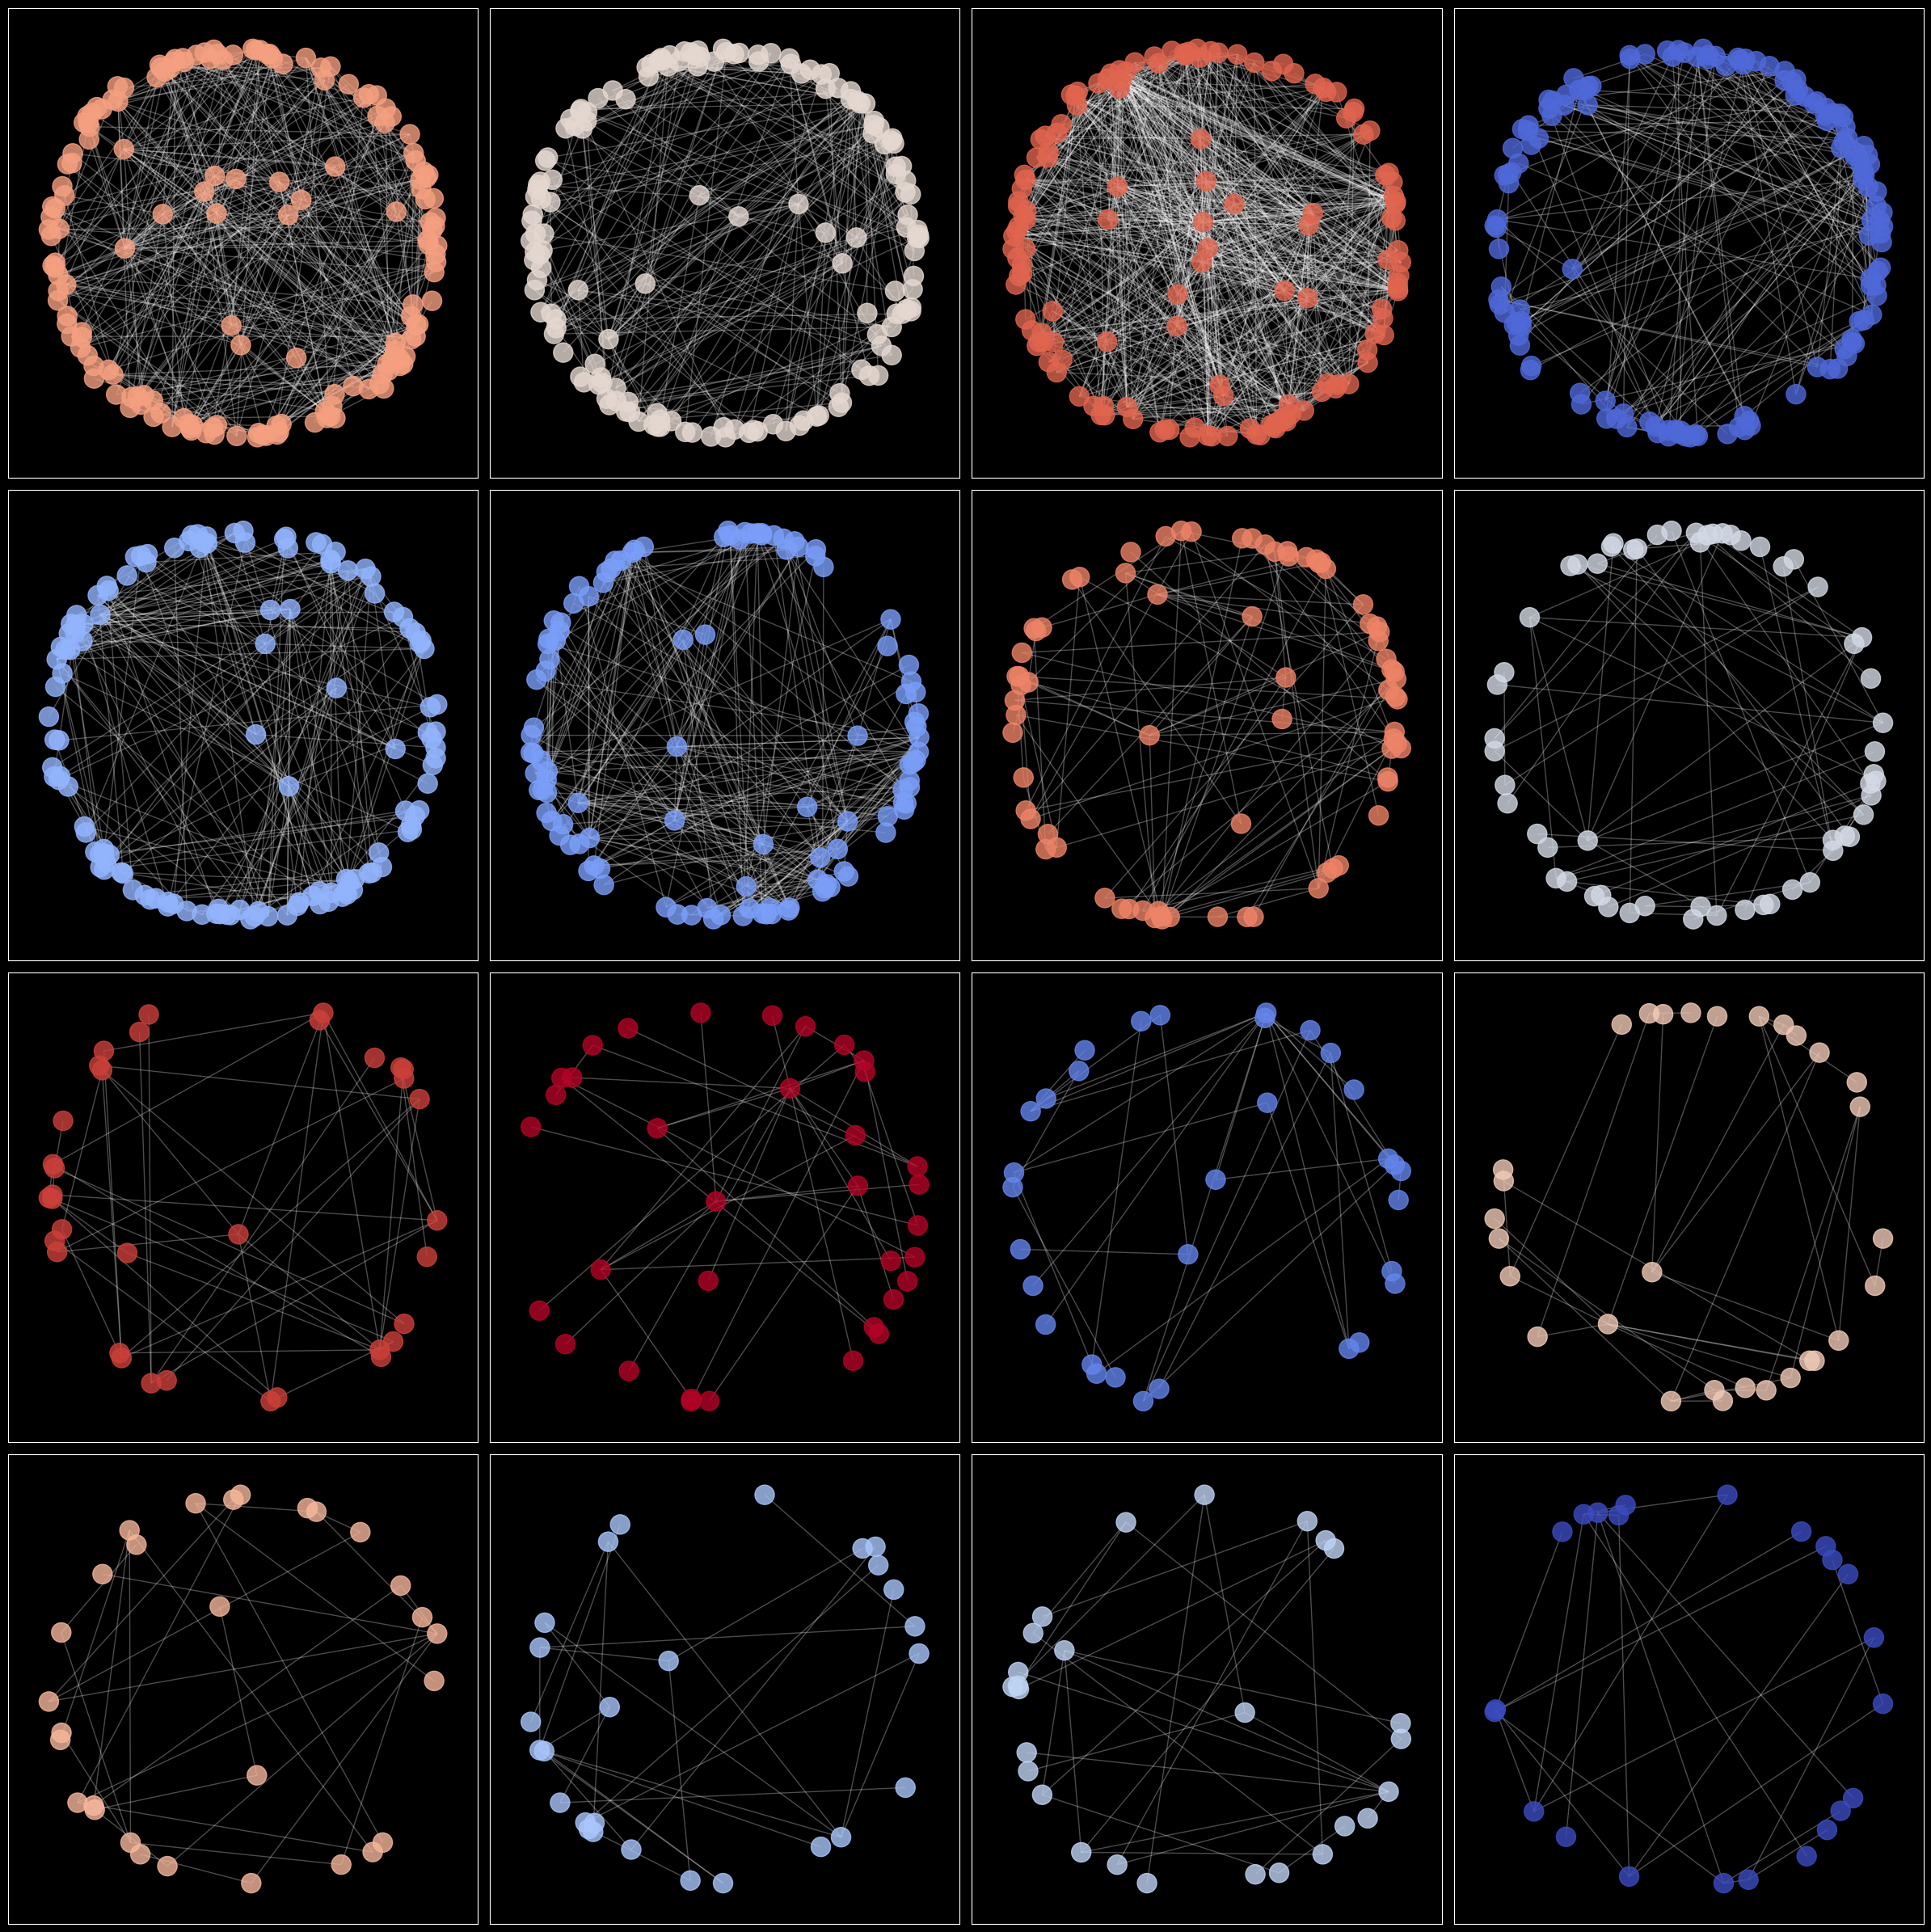

In [122]:
gen = gen_ij(4, 4)  # init generator for plot positions

plt.figure(figsize=(20, 20))
fig, axes = plt.subplots(4, 4, figsize=(24, 24))

for community, (i, j) in zip(communities_sorted, gen):
    subgraph = G.subgraph(community)

    subpos = {node: pos[node] for node in community}

    node_colors = [cmap(node2community[node]) for node in subgraph.nodes()]

    ax = axes[i, j]
    nx.draw_networkx_nodes(subgraph, subpos, ax=ax,
                           node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(subgraph, subpos, ax=ax,
                           alpha=0.3, edge_color="white", width=1)

plt.tight_layout()
plt.show()